# Gradient Boosting Machines for Wine Price Predictions

In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import RegexpTokenizer
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

In [71]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [72]:
#Load data
wine = pd.read_csv('data/winemag-data_first150k.csv', index_col=0, encoding="utf-8")
wine.dropna(subset=["price"], inplace=True)
wine.reset_index(inplace=True)
print(wine.shape)
wine.head()

(137235, 11)


,index,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [73]:
wine["description"][0]

'This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.'

# Feature Engineering

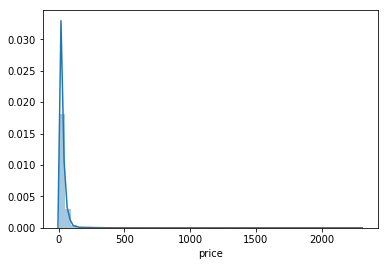

In [74]:
sns.distplot(wine.price)
plt.show()

In [75]:
def ohe_features(df, feature, occurances):
    '''
    df: pandas data frame with feature to be encoded
    feature: str. feature name
    occurances: number of occurances to threshold feature at
    '''
    vc = df[feature].value_counts()
    keep_values = vc[vc > occurances].index.tolist()
    ohe_feature = pd.get_dummies(df[feature])

    feature_names = ohe_feature.columns
    keep_features = feature_names[feature_names.isin(keep_values)]
    return ohe_feature[keep_features]

In [76]:
country = pd.get_dummies(wine.country)
collist = country.columns.tolist()
collist = ["country_" + s for s in collist]
country.columns = collist
print ("There are {} country categorical variables".format(country.shape[1]))

designation = ohe_features(wine, "designation", 50)
collist = designation.columns.tolist()
collist = ["designation_" + s for s in collist]
designation.columns = collist
print ("There are {} designation categorical variables".format(designation.shape[1]))

province = ohe_features(wine, "province", 50)
collist = province.columns.tolist()
collist = ["province_" + s for s in collist]
province.columns = collist
print ("There are {} province categorical variables".format(province.shape[1]))

region = ohe_features(wine, "region_1", 50)
collist = region.columns.tolist()
collist = ["region_" + s for s in collist]
region.columns = collist
print ("There are {} region categorical variables".format(region.shape[1]))

variety = ohe_features(wine, "variety", 50)
collist = variety.columns.tolist()
collist = ["variety_" + s for s in collist]
variety.columns = collist
print ("There are {} variety categorical variables".format(variety.shape[1]))

winery = ohe_features(wine, "winery", 50)
collist = winery.columns.tolist()
collist = ["winery_" + s for s in collist]
winery.columns = collist
print ("There are {} winery categorical variables".format(winery.shape[1]))

There are 46 country categorical variables
There are 71 designation categorical variables
There are 113 province categorical variables
There are 308 region categorical variables
There are 133 variety categorical variables
There are 454 winery categorical variables


In [77]:
def make_lower_case(text):
    return text.lower()

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [78]:
wine["description"] = wine["description"].str.replace('\d+', '')
wine["description"] = wine.description.apply(func=remove_punctuation)
wine["description"] = wine.description.apply(func=make_lower_case)

In [79]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=5)

#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(wine.description)
lsa_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 5))
collist = ["latent_description_" + s for s in collist]
lsa_features.columns = collist
lsa_features.head()

,latent_description_0,latent_description_1,latent_description_2,latent_description_3,latent_description_4
0,0.122660,-0.036761,-0.006784,0.022525,-0.030829
1,0.135296,-0.043047,0.012895,0.026212,0.026648
2,0.077102,0.046806,-0.016269,0.010222,0.014536
3,0.147137,-0.097861,0.031628,0.009989,0.040519
4,0.083745,0.001338,-0.080732,0.103298,-0.019988


In [80]:
X = pd.concat([country, designation, region, variety, winery, lsa_features, wine["points"]], sort=False, axis=1)
y = wine["price"]
print (X.shape)
print (y.shape)

(137235, 1018)
(137235,)


# Test Train Split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print ("{} training observations".format(X_train.shape[0]))
print ("{} testing observations".format(X_test.shape[0]))

96064 training observations
41171 testing observations


# XGBoost Classification

In [82]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [83]:
param = {'max_depth': 3, 'eta': 1, 'subsample':0.5, 'alpha':1}
param['nthread'] = 4
param['eval_metric'] = 'mae'
param['objective'] = 'reg:linear'
param['silent'] = 1
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [84]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	eval-mae:14.4429	train-mae:14.4733
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 10 rounds.
[1]	eval-mae:14.1207	train-mae:14.1609
[2]	eval-mae:13.765	train-mae:13.7806
[3]	eval-mae:13.7872	train-mae:13.8315
[4]	eval-mae:13.6883	train-mae:13.7176
[5]	eval-mae:13.3712	train-mae:13.4043
[6]	eval-mae:13.3228	train-mae:13.324
[7]	eval-mae:13.3066	train-mae:13.3061
[8]	eval-mae:13.1547	train-mae:13.1476
[9]	eval-mae:13.1135	train-mae:13.0928


In [85]:
pred = pd.DataFrame(y_test.copy())
pred["prediction"] = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
pred["prediction"] = np.round(pred["prediction"],0)
pred.sample(5)

,price,prediction
65383,15.0,24.0
52152,24.0,17.0
1768,200.0,64.0
94734,24.0,33.0
52418,35.0,43.0


In [86]:
from sklearn.metrics import median_absolute_error, mean_absolute_error
mean_ae = np.round(mean_absolute_error(y_true=pred["price"], y_pred=pred["prediction"]),2)
median_ae = np.round(median_absolute_error(y_true=pred["price"], y_pred=pred["prediction"]),2)
print ("Mean Absolute Error: ${}".format(mean_ae))
print ("Median Absolute Error: ${}".format(median_ae))

Mean Absolute Error: $13.09
Median Absolute Error: $8.0


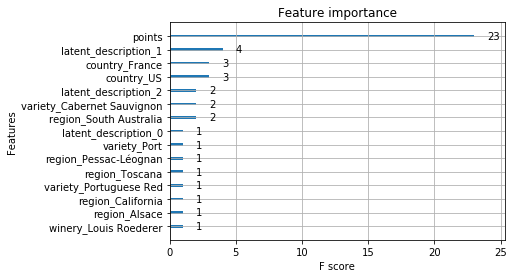

In [87]:
xgb.plot_importance(bst,max_num_features=15)

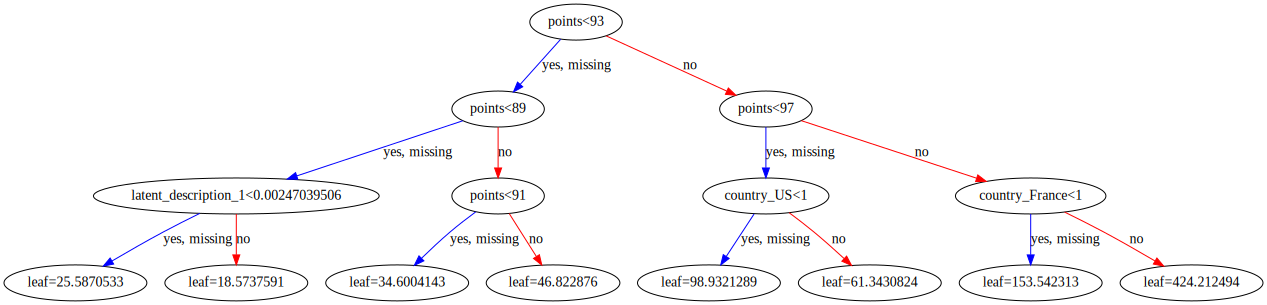

In [88]:
xgb.to_graphviz(bst, num_trees=0)

# DIY Deployment

In [89]:
# I wrote my own predict method 
# Use business logic to filter predictions, not just the models basic predict
# send info in and out as a dictionary/json

In [90]:
def my_own_predict_method(feature_payload):
    
    message_cheap = "Wow, what a steal!"
    message_expensive = "Yikes, that is a spendy wine!"

    #format payload as a dataframe
    x = pd.DataFrame(feature_payload, index=[0])
    #convert it to cgboost data object
    x = xgb.DMatrix(x, label=y_test)

    #predict wine price from xgboost model
    prediction = bst.predict(x, ntree_limit=bst.best_ntree_limit)
    prediction = np.round(prediction,2)[0]
 
    #personalise message 
    if prediction < 50:
        message = message_cheap
    else:
        message = message_expensive
        
    output = {"price": "$"+str(prediction), "message":message}
    
    return output

In [91]:
#get an example payload from the test data
feature_payload = X_test.iloc[5].to_dict()

In [92]:
non_zero_features = [k for k,v in feature_payload.items() if v > 0]
dict((k, feature_payload[k]) for k in non_zero_features if k in feature_payload)

{'country_US': 1.0,
 'region_Carmel Valley': 1.0,
 'variety_Cabernet Sauvignon': 1.0,
 'latent_description_0': 0.11161002715750094,
 'points': 84.0}

In [93]:
my_own_predict_method(feature_payload)

/home/ec2-user/SageMaker/wine_price_predictions/venv/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


{'price': '$33.1', 'message': 'Wow, what a steal!'}

In [ ]:
#Now to deploy my own algorithm, I must build a docker container for it. 